In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import scipy.optimize as optimize
import theano
import theano.tensor as T
from theano import pp
from theano import In

% matplotlib inline

import matplotlib as mpl

print mpl.style.available
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=18               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12


[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


In [3]:
## define your image grid

x = np.arange(256)
xx, yy = np.meshgrid(x,x)

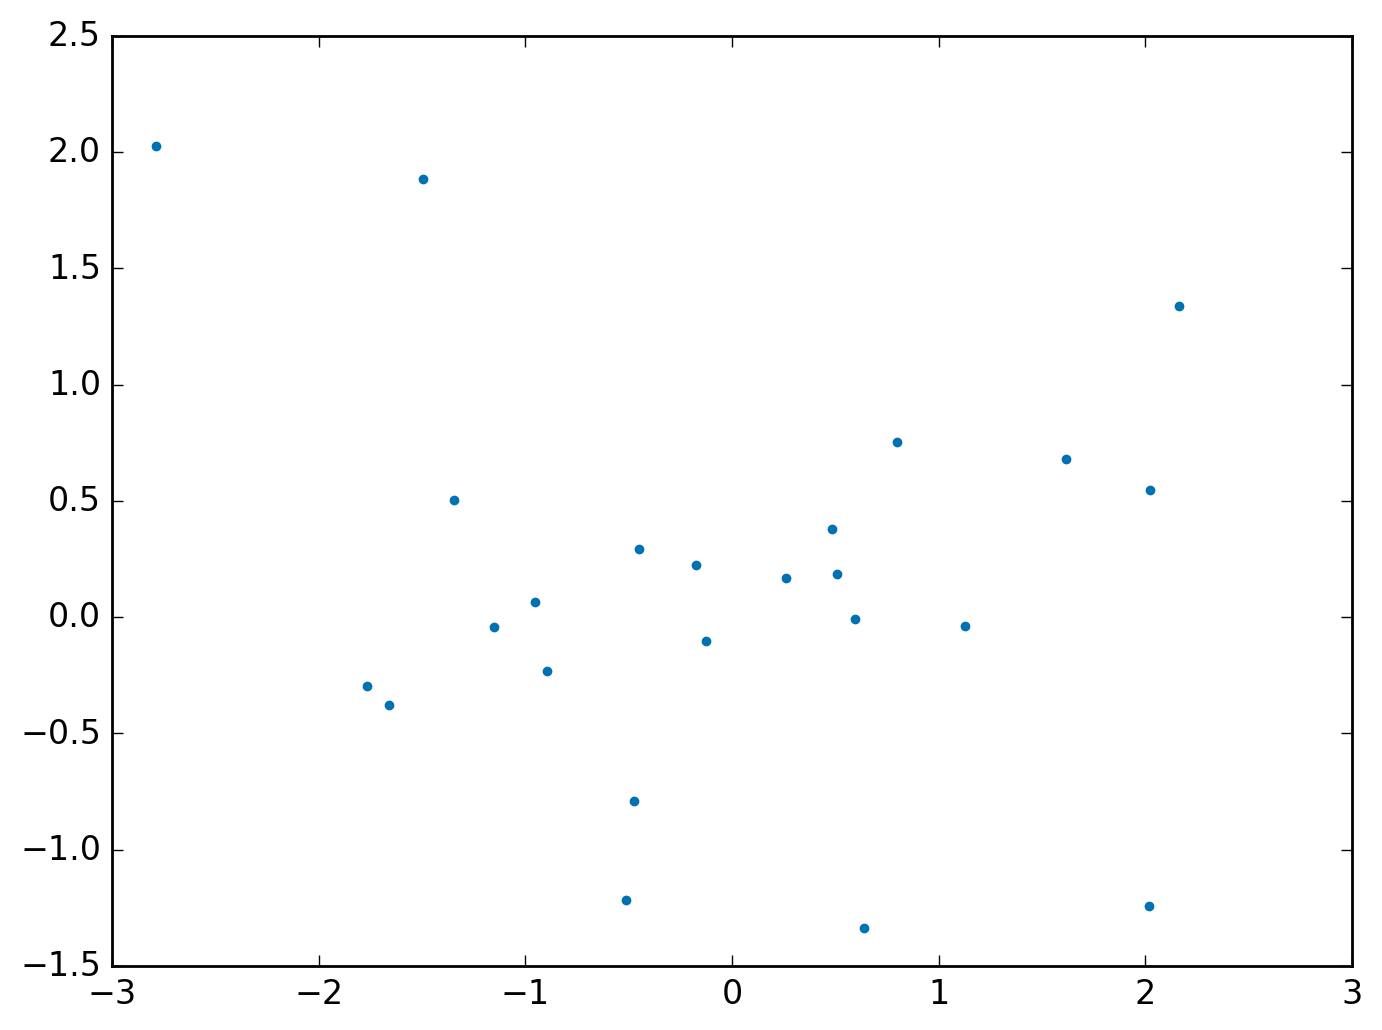

In [149]:
## define your interferometric array

coords = np.random.randn(24,2)
plt.plot(coords[:,0],coords[:,1],'.')

In [150]:
## create your baselines - copied from pysco
ndgt = 6 # number of digits of precision for rounding
prec = 10**(-ndgt)

nbh = coords.shape[0] # local representation of the class variable
uvx = np.zeros(nbh * (nbh-1)) # prepare empty arrays to store
uvy = np.zeros(nbh * (nbh-1)) # the baselines

k = 0 # index for possible combinations (k = f(i,j))

uvi = np.zeros(nbh * (nbh-1), dtype=int) # arrays to store the possible
uvj = np.zeros(nbh * (nbh-1), dtype=int) # combinations k=f(i,j) !!

for i in range(nbh):     # do all the possible combinations of
    for j in range(nbh): # sub-apertures
        if i != j:
            uvx[k] = coords[i,0] - coords[j,0]
            uvy[k] = coords[i,1] - coords[j,1]
            # ---
            uvi[k], uvj[k] = i, j
            k+=1

a = np.unique(np.round(uvx, ndgt)) # distinct u-component of baselines
nbx = a.shape[0]    # number of distinct u-components
uv_sel = np.zeros((0,2))           # array for "selected" baselines

for i in range(nbx):     # identify distinct v-coords and fill uv_sel
    b = np.where(np.abs(uvx - a[i]) <= prec)
    c = np.unique(np.round(uvy[b], ndgt))
    nby = np.shape(c)[0] # number of distinct v-compoments
    app = np.ones(nby)*a[i]
    uv_sel = np.append(uv_sel, np.array([app,c]).T, axis=0)

# hack

uv_sel = 0.1*uv_sel

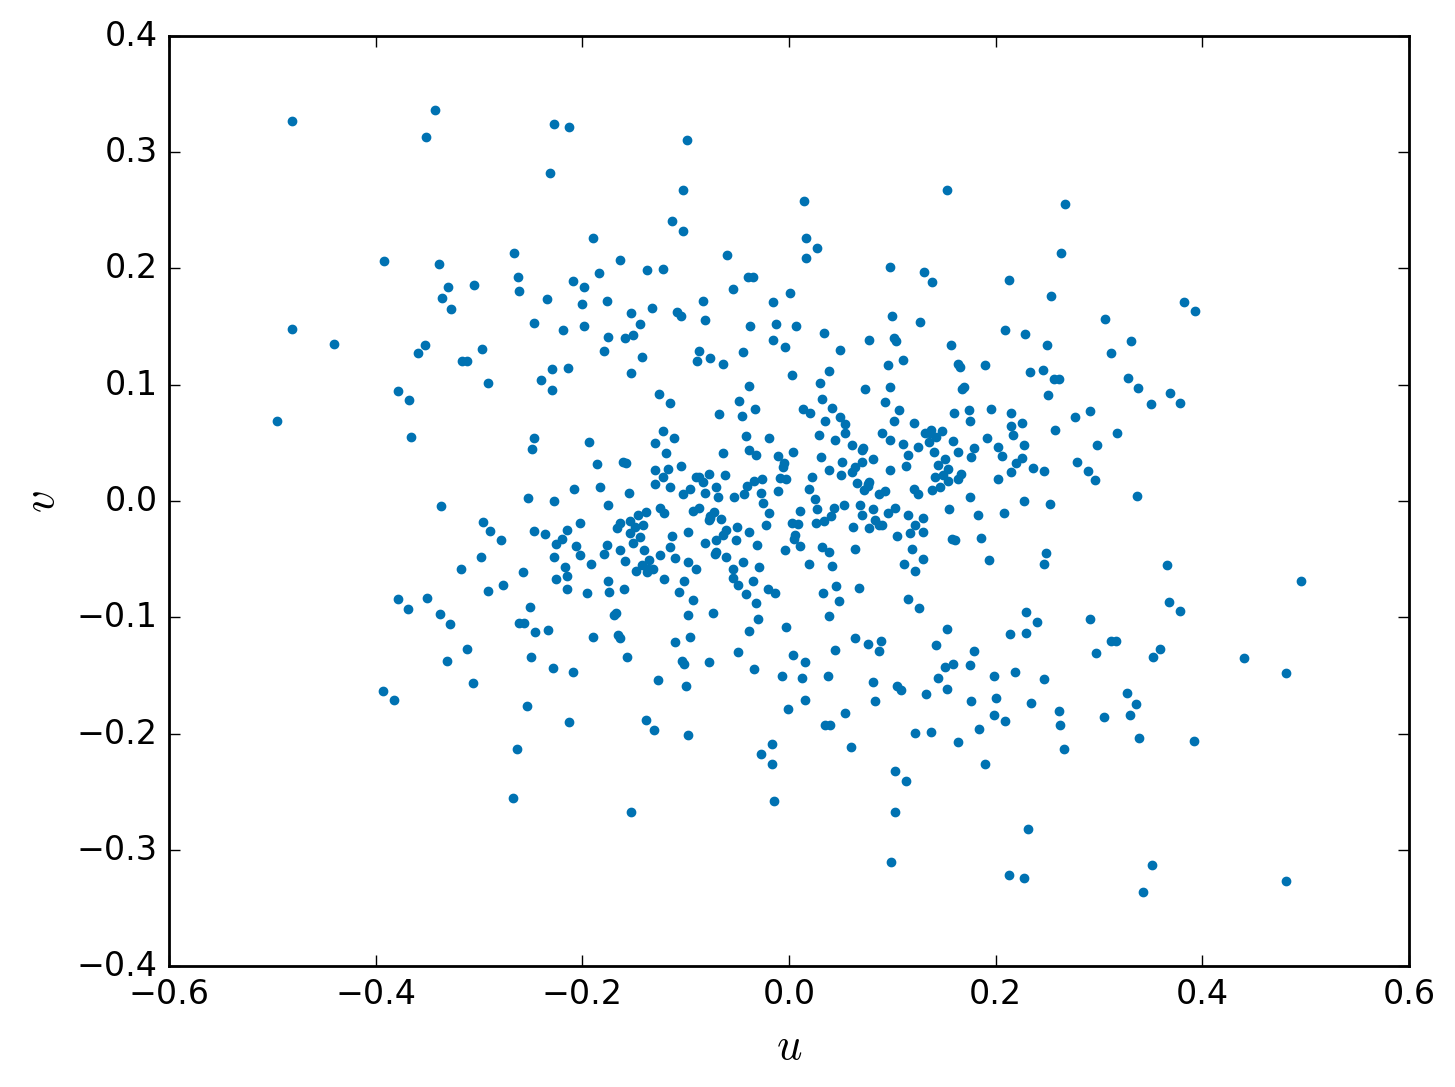

In [151]:
plt.plot(uv_sel[:,0],uv_sel[:,1],'.')
plt.xlabel(r'$u$')
plt.ylabel(r'$v$')

In [156]:
## create p2vm matrix

p2vm_sin = np.zeros((uv_sel.shape[0],xx.ravel().shape[0]))

for j in range(uv_sel.shape[0]):
    p2vm_sin[j,:] = np.ravel(np.sin(xx*uv_sel[j,0]+yy*uv_sel[j,1]))
    
p2vm_cos = np.zeros((uv_sel.shape[0],xx.ravel().shape[0]))

for j in range(uv_sel.shape[0]):
    p2vm_cos[j,:] = np.ravel(np.cos(xx*uv_sel[j,0]+yy*uv_sel[j,1]))

In [139]:
## define gaussian image - from halophot

def gaussian_psf(pixels,xp,yp,width):
    # make rr array
    npix = np.shape(pixels[0])[0]
    xx,yy = np.meshgrid(np.arange(npix)-npix/2.,np.arange(npix)-npix/2.)
    rr2 = (xx-xp)**2 + (yy-yp)**2
    
    return 1./(width*np.sqrt(2.*np.pi))*np.exp(-0.5*(rr2/width**2))

In [140]:
widths = [5,10,20,20]
xs = [20,-20,-50,90]
ys = [20,60,20,-60]
fs = [5,10,20,30]

In [292]:
image = np.zeros_like(xx)*1.
pixels = np.zeros_like(xx)
for j, w in enumerate(widths):
    image += fs[j]*gaussian_psf(pixels,xs[j],ys[j],w)
    
# image /= image.sum()

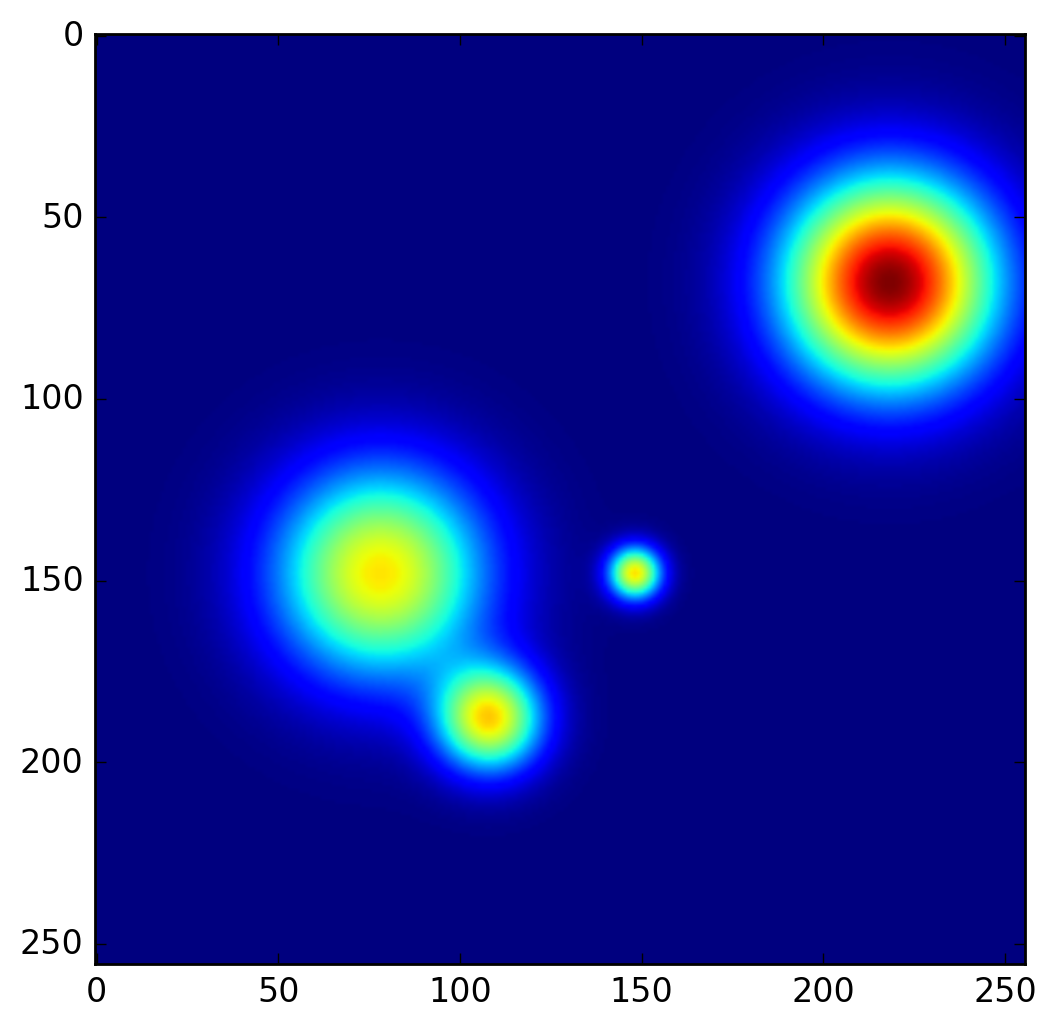

In [293]:
plt.imshow(image)

In [294]:
data_sin = np.dot(p2vm_sin,image.ravel())
data_cos = np.dot(p2vm_cos,image.ravel())

In [295]:
### straight fourier reconstruction

recon = np.zeros_like(image)*1.

for j in range(data_sin.shape[0]):
    recon +=  data_sin[j]*(np.sin(xx*uv_sel[j,0]+yy*uv_sel[j,1]))
    recon +=  data_cos[j]*(np.cos(xx*uv_sel[j,0]+yy*uv_sel[j,1]))


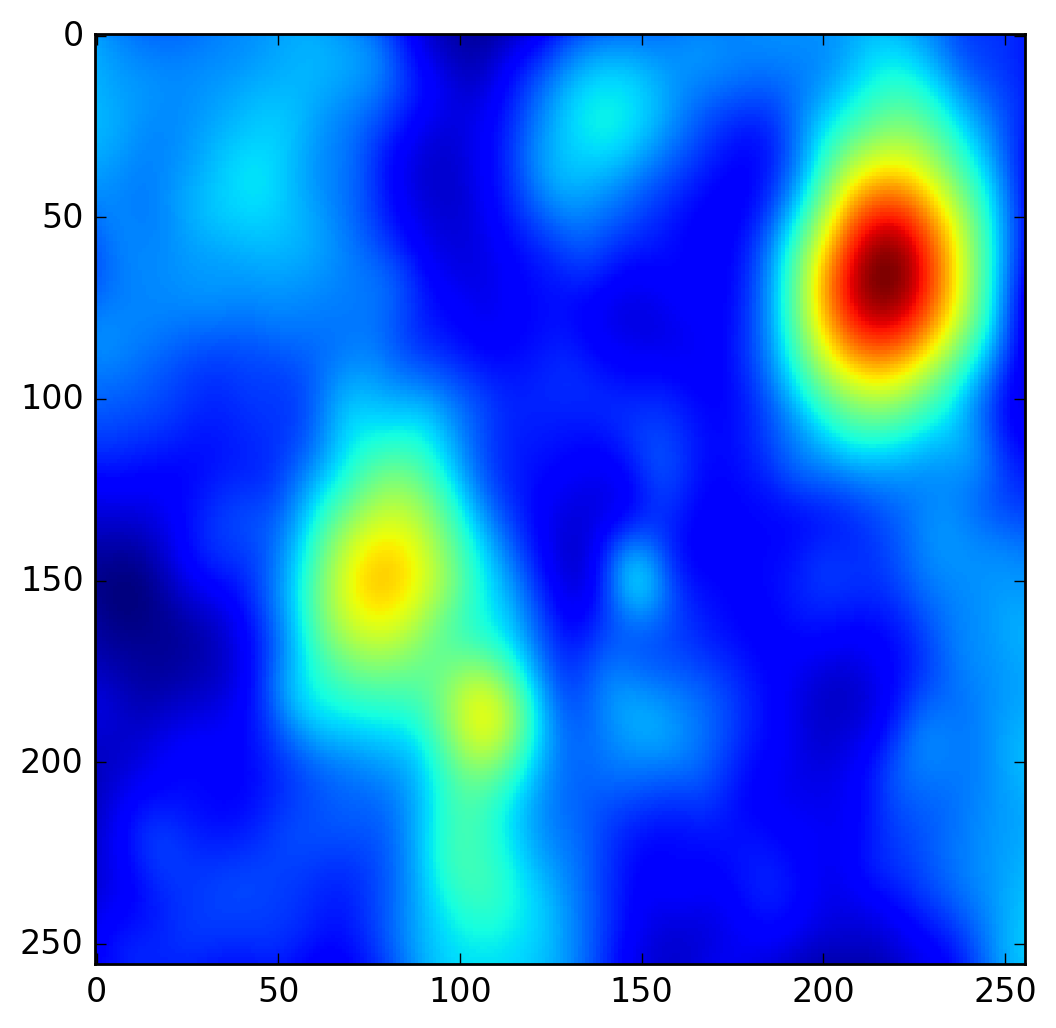

In [296]:
plt.imshow(recon,interpolation='None')

## Now we want to try using a Theano regularized image reconstruction code to do a better job

In [337]:
# imm = T.dvector('imm')
# im = T.nnet.softmax(imm)
im = T.dvector('im')
tp2vm_sin = T.dmatrix('tp2vm_sin')
tp2vm_cos = T.dmatrix('tp2vm_cos')
tdata_sin = T.dvector('tdata_sin')
tdata_cos = T.dvector('tdata_cos')

logloss = T.sum(((tdata_sin - T.dot(tp2vm_sin,im)) + (tdata_cos - T.dot(tp2vm_cos,im)))**2)
imscaled = T.nnet.softmax(im)
entropy = 0.1*T.sum(imscaled * T.log(imscaled))


In [338]:
gll = T.grad(logloss+entropy, im)

In [339]:
dll = theano.function([im,In(tp2vm_sin,value=p2vm_sin),In(tp2vm_cos,value=p2vm_cos),
                       In(tdata_sin,value=data_sin),In(tdata_cos,value=data_cos)],logloss+entropy)


dgradll = theano.function([im,In(tp2vm_sin,value=p2vm_sin),In(tp2vm_cos,value=p2vm_cos),
                       In(tdata_sin,value=data_sin),In(tdata_cos,value=data_cos)],gll)

In [340]:
dll(im_init)

array(5357680577.488829)

In [341]:
im_init = 1.*np.ones_like(xx.ravel())
maxiter= 500

res = optimize.minimize(dll, im_init, method='L-BFGS-B', jac=dgradll, 
    options={'disp': False,'maxiter':maxiter})

In [342]:
# final_im = np.exp(res['x'])/np.sum(np.exp(res['x']))
final_im =  res['x'].reshape(xx.shape)

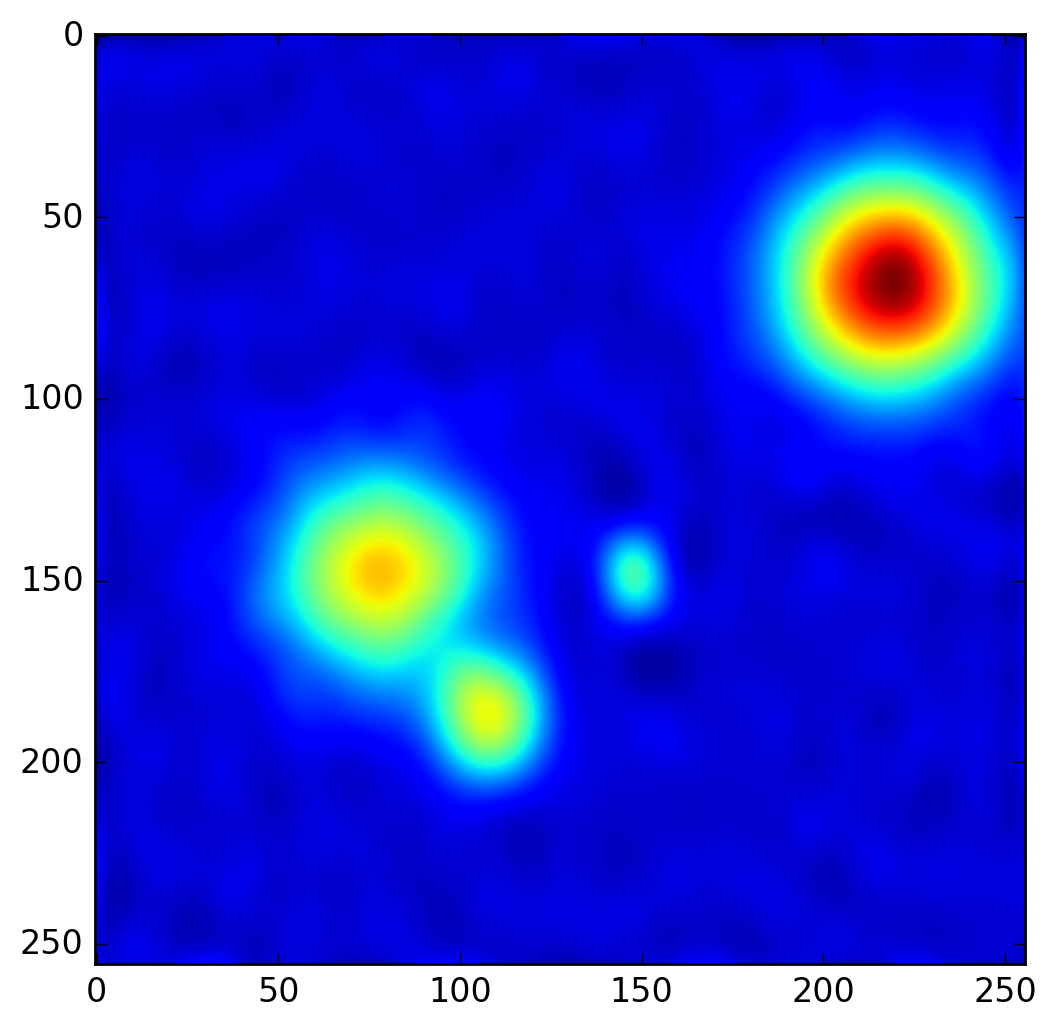

In [343]:
plt.imshow(final_im)

0.82099430638086068